# Identify Items That Use Insecure URLs

> * 👟 Ready To Run!
* 🗄️ Administration
* 📦 Content Management

Items of type WebMap, WebScene, or App contain collections of layers, basemaps, and other external services hosted on ArcGIS Online/Server. These services can be connected to via `http://` or `https://`, with HTTPS being the more secure protocol since it encrypts the connection. __It is recommended that all service URLs use the `https://` (or say, SSL) protocol__.

This notebook will search through all WebMap/WebScene/App Items in a portal/organization, identifying the 'insecure' ones if one or more service URLs use `http://`. These items will be displayed in this notebook, persisted in `.csv` files, and can have the `potentially_insecure` tag added to them.

<h1>**Table of Contents**<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Identify-Items-That-Use-Insecure-URLs" data-toc-modified-id="Identify-Items-That-Use-Insecure-URLs-1">Identify Items That Use Insecure URLs</a></span><ul class="toc-item"><li><span><a href="#Configure-Behavior" data-toc-modified-id="Configure-Behavior-1.1">Configure Behavior</a></span></li><li><span><a href="#Detecting-http-vs-https" data-toc-modified-id="Detecting-http-vs-https-1.2">Detecting http vs https</a></span><ul class="toc-item"><li><span><a href="#WebMaps" data-toc-modified-id="WebMaps-1.2.1">WebMaps</a></span></li><li><span><a href="#WebScenes" data-toc-modified-id="WebScenes-1.2.2">WebScenes</a></span></li><li><span><a href="#Apps" data-toc-modified-id="Apps-1.2.3">Apps</a></span></li></ul></li><li><span><a href="#Output-CSV-Files" data-toc-modified-id="Output-CSV-Files-1.3">Output CSV Files</a></span></li><li><span><a href="#Miscellaneous-Functionality" data-toc-modified-id="Miscellaneous-Functionality-1.4">Miscellaneous Functionality</a></span></li><li><span><a href="#main()" data-toc-modified-id="main()-1.5">main()</a></span></li><li><span><a href="#Post-Processing" data-toc-modified-id="Post-Processing-1.6">Post Processing</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-2">Conclusion</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Rewrite-this-Notebook" data-toc-modified-id="Rewrite-this-Notebook-2.0.1">Rewrite this Notebook</a></span></li><li><span><a href="#Related-Notebooks" data-toc-modified-id="Related-Notebooks-2.0.2">Related Notebooks</a></span></li></ul></li></ul></li></ul></div>

To get started, import the necessary libraries and connect to our GIS:

In [1]:
import csv, os
import time
from IPython.display import display, HTML
import json
import pandas
import logging
log = logging.getLogger()

from arcgis.mapping import WebMap
from arcgis.mapping import WebScene
from arcgis.gis import GIS

gis = GIS('Home')

## Configure Behavior

Now, let's configure some variables specific to our organization that will tell our notebook how we want it to run. With the default `CHECK_ALL_ITEMS` set to `True`, this notebook will apply this check to all items an organization/portal. If you would instead prefer to only apply this check to certain groups of items, set `CHECK_ALL_ITEMS` to `False`, then set `GROUP_NAMES` to a list of group name strings.

Modify the below cell to change that default behavior.

In [2]:
# Set to `True` if you would like to check ALL items in an org/portal
CHECK_ALL_ITEMS = True
# If `CHECK_ALL_ITEMS` is `False`, then it will check all items in these groups
CHECK_THESE_GROUPS = ['group_name_1', 'group_name_2']

Now, let's specify what types of items we want to test. By default, this notebook will check `WebMap`, `WebScene`, and any `App` items.

Modify the below cell to change that default behavior.

In [3]:
CHECK_WEBMAPS = True
CHECK_WEBSCENES = True
CHECK_APPS = True

Now, let's specify what kind of behavior we want when we come across an insecure item. This notebook will automatically sort and display the insecure and secure items, but we can also configure if we want to add a `potentially_insecure` tag to all insecure items.

The default behavior is __NOT__ to add the tag. Modify the below cell to change that default behavior.

In [4]:
TRY_TAG_INSECURE_ITEMS = False

## Detecting http vs https

A core component of this notebook will be detecting if a URL is `http://` or `https://`. We will do this by creating helper functions that use the built-in string library to see what the URL string starts with.

In [5]:
def is_https(url):
    return str(url).startswith("https:/")

def is_http(url):
    return str(url).startswith("http:/")

### WebMaps

This code cell defines a function that will test all URLs in a web map item; it will return the URLs that use `https://` and the URLs that use `http://`.

In [6]:
def test_https_in_webmap(webmap_item):
    """Takes in an `Item` class instance of a Web Map Item.
    Sorts all operational layers and basemap layers based on if
    they are http or https, returns a tuple of 
    (https_urls, http_urls), with each being a list of URLs
    """
    https_urls = []
    http_urls = []
    wm = WebMap(webmap_item)

    # Concatenate all operational layers and basemap layers to one list
    all_layers = list(wm.layers)
    if hasattr(wm.basemap, 'baseMapLayers'):
        all_layers += wm.basemap.baseMapLayers

    # Test all of the layers, return the results
    for layer in [layer for layer in all_layers \
                  if hasattr(layer, 'url')]:
        if is_https(layer.url):
            log.debug(f"    [✓] url {layer['url']} is https")
            https_urls.append(layer.url)
        elif is_http(layer.url):
            log.debug(f"    [X] url {layer['url']} is http")
            http_urls.append(layer.url)
    return (https_urls, http_urls)

### WebScenes

This code cell defines a function that will test all URLs in a web scene item; it will return the URLs that use `https://` and the URLs that use `http://`.

In [7]:
def test_https_in_webscene(webscene_item):
    """Takes in an `Item` class instance of a web scene item.
    Sorts all operational layers and basemap layers based on if
    they are http or https, returns a tuple of 
    (https_urls, http_urls), with each being a list of URLs
    """
    https_urls = []
    http_urls = []
    ws = WebScene(webscene_item)

    # Concatenate all operational layers and basemap layers to 1 list
    all_layers = []
    for operationalLayer in ws.get('operationalLayers', []):
        if 'layers' in operationalLayer:
            for layer in operationalLayer['layers']:
                all_layers.append(layer)
        else:
            all_layers.append(operationalLayer)
    for bm_layer in ws.get('baseMap', {}).get('baseMapLayers', []):
        all_layers.append(bm_layer)

    # Test all of the layers, return the results
    for layer in [layer for layer in all_layers \
                  if layer.get('url', False)]:
        if is_https(layer.get('url', False)):
            log.debug(f"    [✓] url {layer['url']} is https")
            https_urls.append(layer['url'])
        elif is_http(layer.get('url', False)):
            log.debug(f"    [X] url {layer['url']} is http")
            http_urls.append(layer['url'])
    return (https_urls, http_urls)

### Apps

This code cell defines a function that will test all URLs in an app item; it will return the URLs that use `https://` and the URLs that use `http://`.

>__Note__: App items don't have as standardized of JSON format as WebMaps and WebScenes. Therefore, the logic used to detect URLs in App Items will test every nested value in the dictionary returned from a `get_data()` call.

In [8]:
def get_values_recurs(dict_):
    """Helper function to get all nested values in a dict."""
    output = []
    if isinstance(dict_, dict):
        for value in dict_.values():
            if isinstance(value, dict):
                output += get_values_recurs(value)
            elif isinstance(value, list):
                for entry in value:
                    output += get_values_recurs({"_":entry})
            else:
                output += [value,]
    return output

def test_https_in_app(app_item):
    """Takes in an `Item` class instance of any 'App' Item.
    Will call `.get_data()` on the Item, and will search through
    EVERY value nested inside the data dict, sorting each URL
    found to either `https_urls` or `http_urls`, returning the 
    tuple of (https_urls, http_url)
    """
    https_urls = []
    http_urls = []
    all_values = get_values_recurs(app_item.get_data())
    for value in all_values:
        if is_https(value):
            https_urls.append(value)
        elif is_http(value):
            http_urls.append(value)
    return (https_urls, http_urls)

The previously defined `test_https_...()` functions all follow a similar prototype of returning a tuple of `(https_urls, http_urls)`. We can therefore define a helper function will sort for us and call the correct function, based on the `item.type` property and the previously defined configuration variables.

In [9]:
def test_https_for(item):
    """Given an `Item` instance, call the correct function and return 
    (https_urls, http_urls). Will return (None, None) if the item type 
    is not supported, or if configured to not check that item type.
    """
    if (item.type == "Web Map") and CHECK_WEBMAPS:
        return test_https_in_webmap(item)
    elif (item.type == "Web Scene") and CHECK_WEBSCENES:
        return test_https_in_webscene(item)
    elif ("App" in item.type) and CHECK_APPS:
        return test_https_in_app(item)
    else:
        return ([],[])

## Output CSV Files

We will be persisting the results of this notebook as two `.csv` files in the `/arcgis/home` folder, which will then also publish to our portal.

One `.csv` file (`ALL_URLS.csv`) will contain one row per URL. This file will contain an in-depth, comprehensive look of all secure/insecure URLs and how they related to items. This file is best analyzed by filtering in desktop spreadsheet software, manipulating in a `pandas` DataFrame, etc.

The other `.csv` file (`INSECURE_ITEMS.csv`) will contain one row per Item. This will be a useful, 'human-readable' table that will give us a quick insight into what items contain insecure URLs.

Let's create a `create_csvs()` function that creates these files with the appropriate columns and unique filenames; it will be called on notebook start.

In [10]:
from pathlib import Path

In [11]:
insecure_items_columns = ['item_id', 'item_title', 'item_url',
                         'item_type', 'https_urls', 'http_urls']
all_urls_columns = ['url', 'is_secure', 'item_id', 
                    'item_title', 'item_url', 'item_type']

workspace = "/arcgis/home"

if not os.path.exists(workspace):
    os.makedirs(workspace)

def create_csvs():
    """When called, will create the two output .csv files with unique 
    filenames. Returns a tuple of the string file paths
    (all_urls_path, insecure_items_path)
    """
    all_urls_path = Path(f'{workspace}/ALL_URLs-{time.ctime()}.csv')
    insecure_items_path = f'{workspace}/INSECURE_ITEMS-{time.ctime()}.csv'
    for file_path, columns in [(all_urls_path, all_urls_columns),
                   (insecure_items_path, insecure_items_columns)]:
        with open(file_path, 'w') as file:
            writer = csv.DictWriter(file, columns)
            writer.writeheader()
    return (all_urls_path, insecure_items_path)

Now that the `.csv` files have been made with the correct headers/columns, we can create a function to add a row to the `ALL_URLS.csv` file. Each URL gets its own row, an `is_secure` boolean, and information related to the item the URL came from (item id, item type, etc.).

In [13]:
def write_row_to_urls_csv(url, is_secure, item, file_path):
    """Given any URL from an item we've tested, write a
    row to the output 'ALL_URLs.csv', located at `file_path`. This .csv
    will have 1 row per URL, with information such as an `is_secure`
    boolean, information about the item that contained the URL, etc.
    """
    with open(file_path, 'a') as file:
        writer = csv.DictWriter(file, all_urls_columns)
        writer.writerow({'url' : url,
                         'is_secure' : is_secure,
                         'item_id' : item.id,
                         'item_title' : item.title,
                         'item_url' : item.homepage,
                         'item_type' : item.type})

Next, we can create a function to add a row to the `INSECURE_ITEMS.csv` file. In this file, each Item gets its own row, with related information like its item id, item url, a JSON representation of the https_urls, a JSON representation of http_urls, etc.

In [14]:
def write_row_to_insecure_csv(item, https_urls, http_urls, file_path):
    """Given an insecure item, write a row to the output 
    'INSECURE_URLS.csv' file, located at `file_path`. This .csv will 
    have 1 row per item, with information such as the item's ID,the 
    item's URL, a JSON representation of the list of http_urls and 
    https_urls, etc.
    """
    with open(file_path, 'a') as file:
        writer = csv.DictWriter(file, insecure_items_columns)
        writer.writerow({'item_id' : item.id,
                         'item_title' : item.title,
                         'item_url' : item.homepage,
                         'item_type' : item.type,
                         'https_urls' : json.dumps(https_urls),
                         'http_urls' : json.dumps(http_urls)})

## Miscellaneous Functionality

Another way we can persist the results from this notebook is to attempt to add a tag of `potentially_insecure` to all the insecure items we find via this function.

> __Note__: An exception will NOT be thrown if an item's tag cannot be updated due to permissions, not being the item owner, etc. A warning message will be logged, but the function will return and the notebook will continue.

In [15]:
def try_tag_item_as_insecure(item):
    """Will attempt to add a tag to the item that will mark it as 
    potentially insecure. If the tag cannot be updated (permissions,
    not the owner, etc.), this function will still return, but it
    will print out a WARNING message
    """
    try:
        tag_to_add = "potentially_insecure"
        if tag_to_add not in item.tags:
            item.update({'tags': item.tags + [tag_to_add]})
    except Exception as e:
        log.warning(f"Could not tag item {item.id} as '{tag_to_add}'...")

Now, let's create a generator function that will `yield` `Item`(s). This notebook can run against all items in an organization or portal, or all items from certain groups, depending on the value of the previously defined configuration variables.

In [16]:
def get_items_to_check():
    """Generator function that will yield Items depending on how you 
    configured your notebook. Will either yield every item in an 
    organization, or will yield items in specific groups.
    """
    if CHECK_ALL_ITEMS:
        for user in gis.users.search():
            for item in user.items(max_items=999999999):
                # For the user's root folder
                yield item
            for folder in user.folders:
                # For all the user's other folders
                for item in user.items(folder, max_items=999999999):
                    yield item
    else:
        for group_name in CHECK_THESE_GROUPS:
            group = gis.groups.search(f"title: {group_name}")[0]
            for item in group.content():
                yield item

## main()

Finally, let's create our `main()` function that links together all our previously defined functions that get all our web maps, web scenes, and apps, test the items, and write the results to the correct places.

In [17]:
# After running main(), these in-memory variables will be populated
secure_items = []
insecure_items = []
all_urls_csv_item = None
insecure_items_csv_item = None

def main():
    # Tell user we're running, initialize variables/files
    print("Notebook is now running, please wait...\n-----")
    global secure_items, insecure_items, \
        all_urls_csv_item, insecure_items_csv_item
    secure_items = []
    insecure_items = []
    all_urls_path, insecure_items_path = create_csvs()
    
    # Test each item, write to the appropriate file
    for item in get_items_to_check():
        try:
            print(f"\rChecking item {item.id}", end="")
            https_urls, http_urls = test_https_for(item)

            # add all the item's URLs to the 'ALL_URLs.csv' output file
            for urls, is_secure in [(https_urls, True), (http_urls, False)]:
                for url in urls:
                    write_row_to_urls_csv(url, is_secure, 
                                          item, all_urls_path)

            # If the item is insecure, add to 'INSECURE_ITEMS.csv' out file
            if http_urls:
                insecure_items.append(item)
                write_row_to_insecure_csv(item, https_urls, http_urls,
                                          insecure_items_path)
                if TRY_TAG_INSECURE_ITEMS:
                    try_tag_item_as_insecure(item)
            elif https_urls:
                secure_items.append(item)
        except:
            print(f'unable to process {item}')
            pass

    # Publish the csv files, display them in the notebook
    display(HTML("<h1><u>RESULTS</u><h1>"))
    all_urls_csv_item = gis.content.add({}, all_urls_path)
    display(all_urls_csv_item)
    insecure_items_csv_item = gis.content.add({}, insecure_items_path)
    display(insecure_items_csv_item)

    # Display the items with insecure URLs
    max_num_items_to_display = 10
    display(HTML(f"<h3>{len(insecure_items)} ITEMS "\
                 "USE INSECURE URLs</h3>"))
    for item in insecure_items[0:max_num_items_to_display]:
        display(item)

    # Tell user we're finished
    print("-----\nNotebook completed running.")

We have just defined a `main()` function, but we haven't called it yet. If you've modified the notebook, follow these steps:
1. __Double check the notebook content__. Make sure no secrets are visible in the notebook, delete unused code, refactor, etc.
2. Save the notebook
3. In the 'Kernel' menu, press 'Restart and Run All' to run the whole notebook from top to bottom

Now, `main()` can be called.

Notebook is now running, please wait...
-----
Checking item 8443e3c2473549f0b464a6a3f295acf9unable to process <Item title:"lambda-credit-counter" type:Application owner:amani_geosaurus>
Checking item d856d48766744eaa8a45246b3c2599ceunable to process <Item title:"MyExp22" type:Application owner:DavidJVitale>
Checking item e578814582464021b72b3e15143e43d1

<Item title:"ALL_URLs-Thu Oct  8 16_14_35 2020" type:CSV owner:arcgis_python>

<Item title:"INSECURE_ITEMS-Thu Oct  8 16_14_35 2020" type:CSV owner:arcgis_python>

<Item title:"asdf" type:Web Map owner:DavidJVitale>
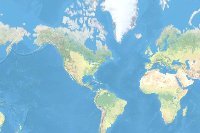

<Item title:"frommapviewer2" type:Web Map owner:DavidJVitale>
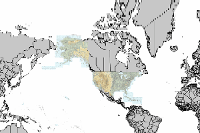

<Item title:"asdf" type:Web Map owner:DavidJVitale>
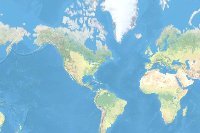

<Item title:"asdf" type:Web Map owner:DavidJVitale>
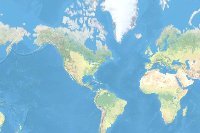

<Item title:"asdf" type:Web Map owner:DavidJVitale>

<Item title:"asdf" type:Web Map owner:DavidJVitale>
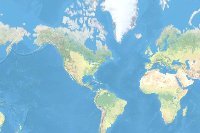

<Item title:"newstuff" type:Web Map owner:DavidJVitale>
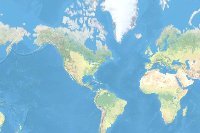

<Item title:"newstuff" type:Web Map owner:DavidJVitale>
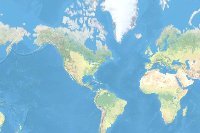

<Item title:"newstuff2" type:Web Map owner:DavidJVitale>
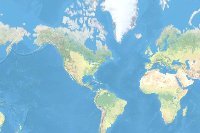

<Item title:"asdf" type:Web Map owner:DavidJVitale>

-----
Notebook completed running.


In [18]:
main()

If configured correctly, this notebook should have output two `.csv` files that can help you identify items that use insecure URLs.

## Post Processing

The `ALL_URLS.csv` file/item contains an in-depth, comprehensive look at all secure and insecure URLs and how they relate to items. This file contains a lot of information, which can be better analyzed using the `pandas` package. This code cell will convert any `.csv` Item to a pandas `DataFrame`; we will be converting the `ALL_URLS.csv` file.

In [19]:
def csv_item_to_dataframe(item):
    """Takes in an Item instance of a `.csv` file,
    returns a pandas DataFrame
    """
    if item is not None:
        downloaded_csv_file_path = item.download()
        return pandas.read_csv(downloaded_csv_file_path)
    else:
        print("csv item not downloaded")
        return None

df = csv_item_to_dataframe(all_urls_csv_item)
if df is not None:
    display(df.head())

,url,is_secure,item_id,item_title,item_url,item_type
0,https://services.arcgisonline.com/ArcGIS/rest/...,True,5d911425a8044bd49f75df77097cc9ea,Python API - Hub demo site,https://geosaurus.maps.arcgis.com/home/item.ht...,Hub Site Application
1,https://s3.amazonaws.com/geohub-assets/templat...,True,5d911425a8044bd49f75df77097cc9ea,Python API - Hub demo site,https://geosaurus.maps.arcgis.com/home/item.ht...,Hub Site Application
2,https://s3.amazonaws.com/geohub-assets/templat...,True,5d911425a8044bd49f75df77097cc9ea,Python API - Hub demo site,https://geosaurus.maps.arcgis.com/home/item.ht...,Hub Site Application
3,https://geosaurus.maps.arcgis.com/sharing/rest...,True,5d911425a8044bd49f75df77097cc9ea,Python API - Hub demo site,https://geosaurus.maps.arcgis.com/home/item.ht...,Hub Site Application
4,https://developers.arcgis.com/python/,True,5d911425a8044bd49f75df77097cc9ea,Python API - Hub demo site,https://geosaurus.maps.arcgis.com/home/item.ht...,Hub Site Application


Now that you have a pandas `DataFrame` instance, you can run `query()` on it,

In [20]:
if df is not None:
    display(df.query("is_secure == False"))

,url,is_secure,item_id,item_title,item_url,item_type
182,http://wms.chartbundle.com/wms,False,10c4a93826d6421baf8b9ec8f92dd736,asdf,https://geosaurus.maps.arcgis.com/home/item.ht...,Web Map
184,http://wms.chartbundle.com/wms,False,55497cebb4784fb19504080dfa44309a,frommapviewer2,https://geosaurus.maps.arcgis.com/home/item.ht...,Web Map
186,http://wms.chartbundle.com/wms,False,a3bc943978844f5d853c4d61728f26a6,asdf,https://geosaurus.maps.arcgis.com/home/item.ht...,Web Map
188,http://wms.chartbundle.com/wms,False,954c4c4e58f841299d4046df0dcd5101,asdf,https://geosaurus.maps.arcgis.com/home/item.ht...,Web Map
190,http://wms.chartbundle.com/wms,False,1f8fea087bc946139cdc4dace1180240,asdf,https://geosaurus.maps.arcgis.com/home/item.ht...,Web Map
192,http://wms.chartbundle.com/wms,False,75011004d6ad42b994a92020306a4590,asdf,https://geosaurus.maps.arcgis.com/home/item.ht...,Web Map
194,http://wms.chartbundle.com/wms,False,1f0190f6f6b443278e45b799f9cc3779,newstuff,https://geosaurus.maps.arcgis.com/home/item.ht...,Web Map
196,http://wms.chartbundle.com/wms,False,b3b7be136d004ad7a5899f4a417ab825,newstuff,https://geosaurus.maps.arcgis.com/home/item.ht...,Web Map
198,http://wms.chartbundle.com/wms,False,b958b7d5c1944c8b84c6229ccede7a1c,newstuff2,https://geosaurus.maps.arcgis.com/home/item.ht...,Web Map
200,http://wms.chartbundle.com/wms,False,daf95218c8624b6a9b28cd28c774fa4b,asdf,https://geosaurus.maps.arcgis.com/home/item.ht...,Web Map


as well as use any of the other powerful pandas functionality to gain more insight into the data.

In [21]:
if df is not None:
    display(df.query("is_secure == True")['item_id'].drop_duplicates())

0      5d911425a8044bd49f75df77097cc9ea
5      8ec563a6886f474c8d991e7748ab4c03
16     cd64fa448d7645849a2e624ff56fc15a
26     43f9a76b53054b8d9c0bb5b887744c5c
29     e43a6ca6678d4288b5947bea032d5460
                     ...               
471    6b6673c0160e45599fef82ae80f357ed
484    25181cd7a0c9411f9a7e7aec410b39f1
492    badb4e6fa24e42d88742e8ae154315b4
498    6daf908e54e5417eb9e7929d06ecbe19
500    ce3d58cace8a49219190c94cf0908f65
Name: item_id, Length: 185, dtype: object

# Conclusion

This notebook provided the workflow for identifying WebMap/WebScene/App Items that use insecure URLs and placed the results in two output `.csv` files. This notebook can be a powerful administrative tool to help you increase the security of your maps and apps. As the saying goes: "Security is always excessive until it's not enough".

### Rewrite this Notebook

This notebook can be rewritten to solve related problems. One of these problems is to identify WebMaps/WebScenes/Apps that contain services from an old ArcGIS Server that you are planning to turn off. Replace the `is_http()` and `is_https()` functions with something like:

```python
def is_from_domain(url):
    return 'old-arcgis-server-domain.com' in url
```

You can then use a lot of the remaining functionality of this notebook to check to make sure that your items would not be affected by turning off the old ArcGIS Server.

### Related Notebooks

For related notebooks, search for the following in your samples notebook gallery:

- Check WebMaps for Broken URLs
